## Implementing Anomaly Detection for Academic Fraud
Anomaly detection is a crucial part of understanding data integrity and ensuring academic records are not manipulated. Here, we will implement strategies to detect irregularities and fraudulent patterns in academic records by applying machine learning techniques and statistical methods. This process involves using algorithms to identify deviations from normal patterns and flag potential fraud.

Key Steps for Anomaly Detection
1. Data Preprocessing: Prepare the data to ensure that it is suitable for anomaly detection algorithms.
2. Feature Engineering: Create meaningful features to capture the context around grades, such as teacher ID, subject, and student history.
3. Statistical Analysis for Anomalies: Use statistical techniques to detect outliers in academic scores.
3. Machine Learning-Based Anomaly Detection: Use algorithms like Isolation Forest, One-Class SVM, or Local Outlier Factor to identify anomalies.
4. Interpretation and Visualization: Visualize anomalies and interpret the results to identify patterns of irregularities.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Load the academic history dataset with teacher IDs
academic_history_df = pd.read_csv("./DataGeneration/academic_history_data.csv")

# Display the structure of the data
print("Academic History Data:")
academic_history_df.head()


Academic History Data:


,Student ID,Grade Level,Subject,Term,Teacher ID,Test Score,Exam Score,Total Score,Attendance,Cumulative Score,Average Attendance,JAMB Score,Passed Core Subjects,Cumulative Attendance Rate
0,STU001,JSS1,English Studies,First Term,TCH018,28,31,59,70,64.00,72.33,NaN,NaN,83.403509
1,STU001,JSS1,English Studies,Second Term,TCH018,17,36,53,77,64.00,72.33,NaN,NaN,83.403509
2,STU001,JSS1,English Studies,Third Term,TCH018,31,49,80,70,64.00,72.33,NaN,NaN,83.403509
3,STU001,JSS1,Literature in English,First Term,TCH015,32,36,68,92,73.33,87.67,NaN,NaN,83.403509
4,STU001,JSS1,Literature in English,Second Term,TCH015,35,52,87,87,73.33,87.67,NaN,NaN,83.403509


## Step 2: Feature Engineering
For effective anomaly detection, it’s essential to engineer features that can provide a context to identify unusual patterns.

1. Score Differences: Calculate the difference between test and exam scores to see if a student’s performance changed drastically within the same term.
2. Cumulative Performance: Track cumulative scores over different terms to see if there are unusual spikes or declines.
3. Teacher-Based Analysis: Check if students under a particular teacher are consistently scoring higher or lower than expected.

In [2]:
# Calculate score differences and add new features
academic_history_df["Score Difference"] = abs(academic_history_df["Test Score"] - academic_history_df["Exam Score"])
academic_history_df["Term Cumulative Score"] = academic_history_df.groupby(["Student ID", "Subject"])["Total Score"].cumsum()

# Standardize the data for anomaly detection
scaler = StandardScaler()
academic_history_df[["Test Score", "Exam Score", "Total Score", "Score Difference"]] = scaler.fit_transform(
    academic_history_df[["Test Score", "Exam Score", "Total Score", "Score Difference"]]
)


## Step 3: Statistical Analysis for Anomalies
Using standard deviation and interquartile range (IQR) methods to detect outliers in the distribution of grades.

In [3]:
# Define a function to identify statistical anomalies using z-score or IQR
def detect_statistical_anomalies(df, feature):
    # Calculate the Z-score
    df['Z_Score'] = (df[feature] - df[feature].mean()) / df[feature].std()
    # Flag anomalies based on Z-score threshold
    df['Anomaly'] = np.where(np.abs(df['Z_Score']) > 3, True, False)
    return df

# Detect anomalies based on Total Score
academic_history_df = detect_statistical_anomalies(academic_history_df, "Total Score")

# View flagged anomalies
print("Statistical Anomalies Based on Total Score:")
print(academic_history_df[academic_history_df["Anomaly"] == True].head())


Statistical Anomalies Based on Total Score:
Empty DataFrame
Columns: [Student ID, Grade Level, Subject, Term, Teacher ID, Test Score, Exam Score, Total Score, Attendance, Cumulative Score, Average Attendance, JAMB Score, Passed Core Subjects, Cumulative Attendance Rate, Score Difference, Term Cumulative Score, Z_Score, Anomaly]
Index: []


## Step 4: Machine Learning-Based Anomaly Detection
Using Isolation Forest to identify anomalies in academic scores. Isolation Forest is an effective model for identifying outliers in high-dimensional datasets.

In [4]:
from sklearn.ensemble import IsolationForest

# Select features for anomaly detection
features = ["Test Score", "Exam Score", "Total Score", "Score Difference"]

# Fit the Isolation Forest model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
academic_history_df["Fraud_Score"] = isolation_forest.fit_predict(academic_history_df[features])

# Convert the prediction to human-readable labels
academic_history_df["Fraud_Score"] = academic_history_df["Fraud_Score"].map({1: "Normal", -1: "Anomaly"})

# View flagged anomalies
print("Machine Learning-Based Anomalies:")
print(academic_history_df[academic_history_df["Fraud_Score"] == "Anomaly"].head())


Machine Learning-Based Anomalies:
    Student ID Grade Level                      Subject        Term  \
14      STU001        JSS1             Business Studies  Third Term   
102     STU002        JSS1                        Music  First Term   
117     STU002        JSS2        Literature in English  First Term   
134     STU002        JSS2                  Mathematics  Third Term   
153     STU002        JSS2  Christian Religious Studies  First Term   

    Teacher ID  Test Score  Exam Score  Total Score  Attendance  \
14      TCH037    1.661291   -1.562053    -0.129572          93   
102     TCH039   -1.667585   -1.450457    -2.174156          99   
117     TCH015   -1.534430   -1.562053    -2.174156          88   
134     TCH045   -1.401275   -1.673650    -2.174156          84   
153     TCH050   -1.534430   -1.450457    -2.088965          90   

     Cumulative Score  Average Attendance  JAMB Score Passed Core Subjects  \
14              68.67               84.00         NaN     

## Step 5: Identify and Flag Potential Fraud
Using the output of anomaly detection models, flag records that exhibit potential fraud. These could include:

1. Consistent High Grades: Students consistently achieving high scores that deviate significantly from peers.
2. Sudden Score Spikes: Sudden improvements in scores that are not supported by prior performance history.
3. Teacher Irregularities: Patterns where certain teachers have a disproportionately high number of anomalies.

In [5]:
# Identify potential fraud based on anomalies
potential_fraud_df = academic_history_df[academic_history_df["Fraud_Score"] == "Anomaly"]

# Further analysis to identify specific patterns
fraud_by_teacher = potential_fraud_df.groupby("Teacher ID").size().reset_index(name="Anomaly Count")
fraud_by_student = potential_fraud_df.groupby("Student ID").size().reset_index(name="Anomaly Count")

# Display results
print("Potential Fraudulent Records by Teacher:")
print(fraud_by_teacher.sort_values(by="Anomaly Count", ascending=False).head())

print("\nPotential Fraudulent Records by Student:")
print(fraud_by_student.sort_values(by="Anomaly Count", ascending=False).head())


Potential Fraudulent Records by Teacher:
   Teacher ID  Anomaly Count
45     TCH048            452
12     TCH015            258
3      TCH004            254
15     TCH018            252
42     TCH045            249

Potential Fraudulent Records by Student:
    Student ID  Anomaly Count
180     STU186             21
197     STU203             18
547     STU557             17
112     STU116             17
486     STU495             17


## Step 6: Visualization and Reporting
Visualize anomalies using scatter plots and highlight potential fraud in the academic records.

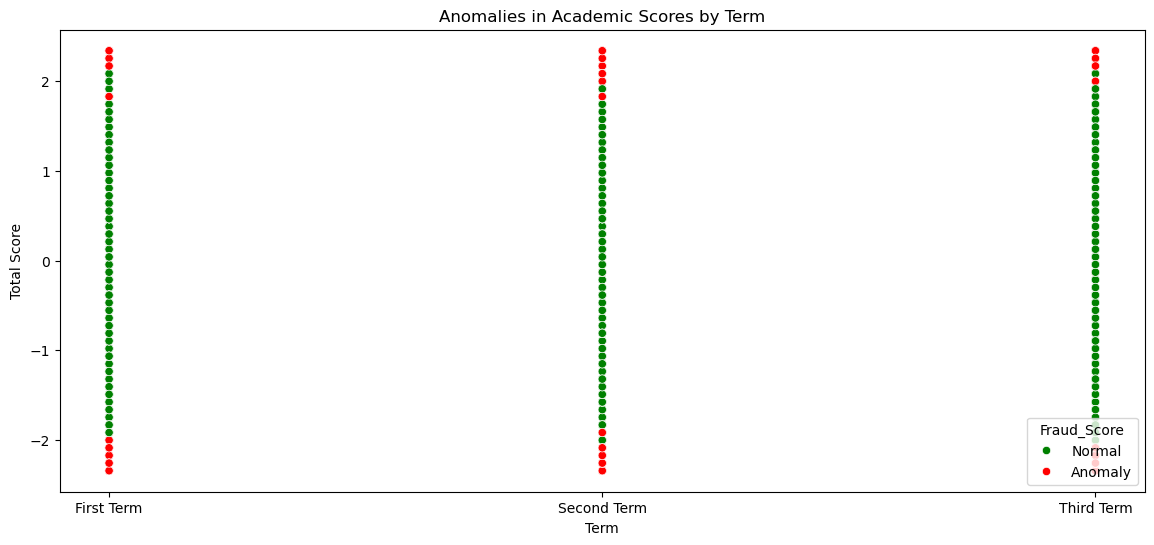

In [6]:
# Scatter plot: Total Score vs. Fraud Score with anomalies highlighted
plt.figure(figsize=(14, 6))
sns.scatterplot(data=academic_history_df, x="Term", y="Total Score", hue="Fraud_Score", palette=["green", "red"])
plt.title("Anomalies in Academic Scores by Term")
plt.xlabel("Term")
plt.ylabel("Total Score")
plt.show()


## Step 7: Actionable Insights and Recommendations
1. Identify At-Risk Teachers and Students: Use the anomaly results to highlight teachers or students who need further review.
2. Targeted Audits: Focus on students with a high anomaly count or teachers who have a disproportionately high number of flagged records.
3. Implement Stronger Controls: Recommend policies or systems for monitoring academic records to prevent fraudulent entries.

## Conclusion
By leveraging both statistical and machine learning-based anomaly detection models, you can flag potential fraud and irregularities in academic records. These insights can help school administrators take preventive measures, improve data integrity, and create a fair academic environment.